In [68]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, concatenate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as sklearn_f1_score, jaccard_score

In [69]:
# Load the lung images and masks from the dataset

image_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/images"
mask_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/masks"

# Function to load images and masks

def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)
        
        img = np.expand_dims(img, axis=-1)
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to 3 channels
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

images, masks = load_data(image_dir, mask_dir)

In [70]:
# Normalize images and masks

images = images / 255.0
masks = masks / 255.0

In [71]:
# Train-test split the dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [72]:
# Define a ResNet-based U-Net model for lung segmentation

def resnet_unet(input_size=(128, 128, 3)):  # Change input size to have 3 channels
    inputs = Input(input_size)

    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Encoder
    s1 = resnet_base.get_layer('conv1_relu').output         # 64x64x64
    s2 = resnet_base.get_layer('conv2_block3_out').output   # 32x32x256
    s3 = resnet_base.get_layer('conv3_block4_out').output   # 16x16x512
    s4 = resnet_base.get_layer('conv4_block6_out').output   # 8x8x1024

    bridge = resnet_base.get_layer('conv5_block3_out').output  # 4x4x2048

    # Decoder
    d1 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(bridge)  # 8x8x1024
    d1 = concatenate([d1, s4])
    d1 = Conv2D(1024, (3, 3), activation='relu', padding='same')(d1)
    d1 = Conv2D(1024, (3, 3), activation='relu', padding='same')(d1)

    d2 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(d1)  # 16x16x512
    d2 = concatenate([d2, s3])
    d2 = Conv2D(512, (3, 3), activation='relu', padding='same')(d2)
    d2 = Conv2D(512, (3, 3), activation='relu', padding='same')(d2)

    d3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d2)  # 32x32x256
    d3 = concatenate([d3, s2])
    d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d3)
    d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d3)

    d4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(d3)  # 64x64x64
    d4 = concatenate([d4, s1])
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d4 = Conv2D(64, (3, 3), activation='relu', padding='same')(d4)

    d5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(d4)  # 128x128x32
    d5 = Conv2D(32, (3, 3), activation='relu', padding='same')(d5)
    d5 = Conv2D(32, (3, 3), activation='relu', padding='same')(d5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d5)

    model = Model(inputs, outputs)
    return model

model = resnet_unet()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 71,965,121 (274.53 MB)

 Trainable params: 71,912,001 (274.32 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [73]:
# Define custom metric functions for evaluating the model performance

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, precision, recall, f1_score, jaccard_index])


In [74]:
# Train the Restnet-based U-net model

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)


Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 79s 197ms/step - accuracy: 0.8873 - dice_coefficient: 0.7066 - f1_score: 0.6628 - jaccard_index: 0.5998 - loss: 0.2224 - precision: 0.7932 - recall: 0.6410 - val_accuracy: 0.7449 - val_dice_coefficient: 0.0208 - val_f1_score: 0.0000e+00 - val_jaccard_index: 0.0105 - val_loss: 1.1624 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.9734 - dice_coefficient: 0.9457 - f1_score: 0.9456 - jaccard_index: 0.8971 - loss: 0.0460 - precision: 0.9560 - recall: 0.9359 - val_accuracy: 0.8101 - val_dice_coefficient: 0.4396 - val_f1_score: 0.4212 - val_jaccard_index: 0.2819 - val_loss: 0.4164 - val_precision: 0.9633 - val_recall: 0.2706
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.9767 - dice_coefficient: 0.9563 - f1_score: 0.9526 - jaccard_index: 0.9163 - loss: 0.0359 - precision: 0.9619 - recall: 0.9436 - val_accuracy: 0.7457 - val_dice_coefficient: 0.1040 - val_f1_s

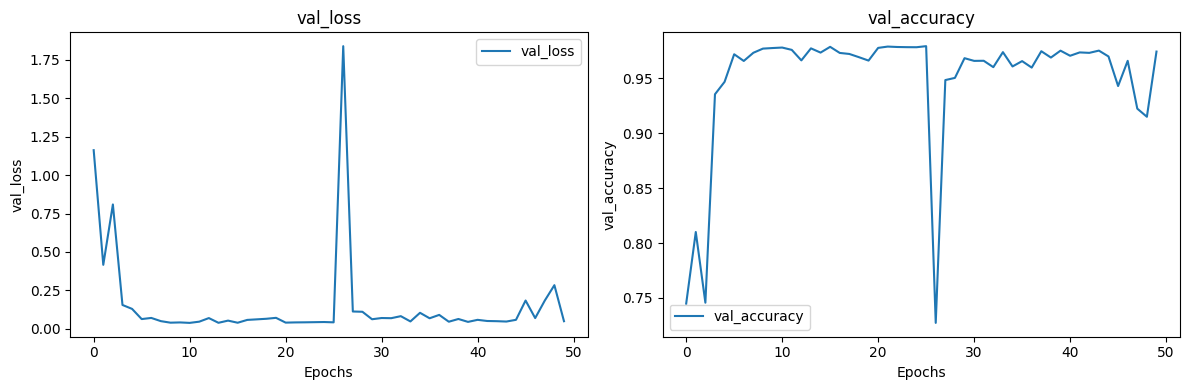

In [75]:
# Plot validation accuracy and validation loss

def plot_val_metrics(history):
    metrics = ['val_loss', 'val_accuracy']
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=metric)
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_val_metrics(history)


In [76]:
# Predict on validation data

preds = model.predict(X_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step


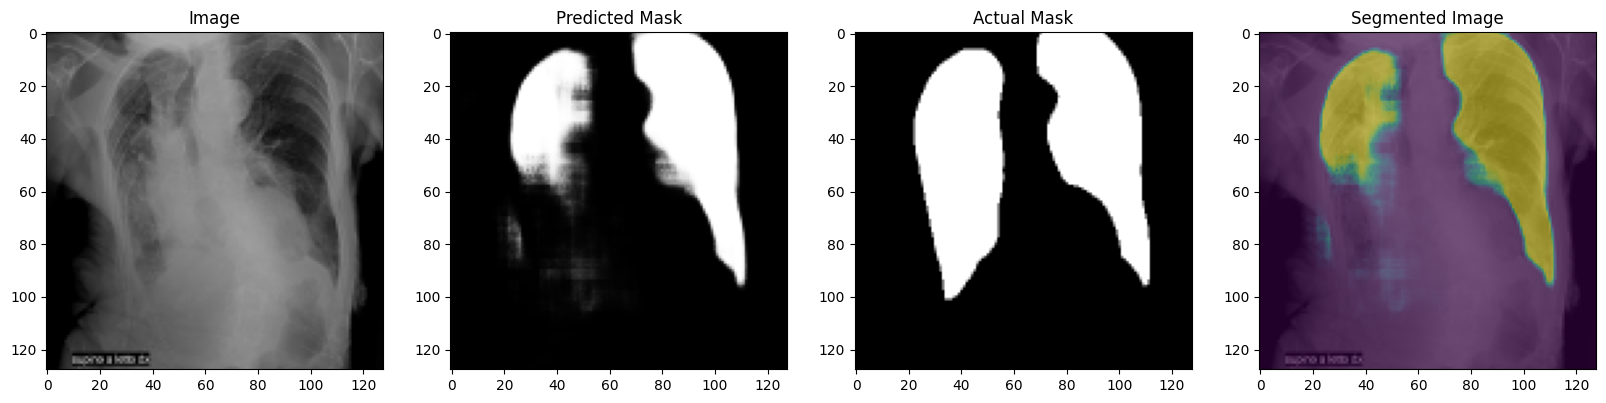

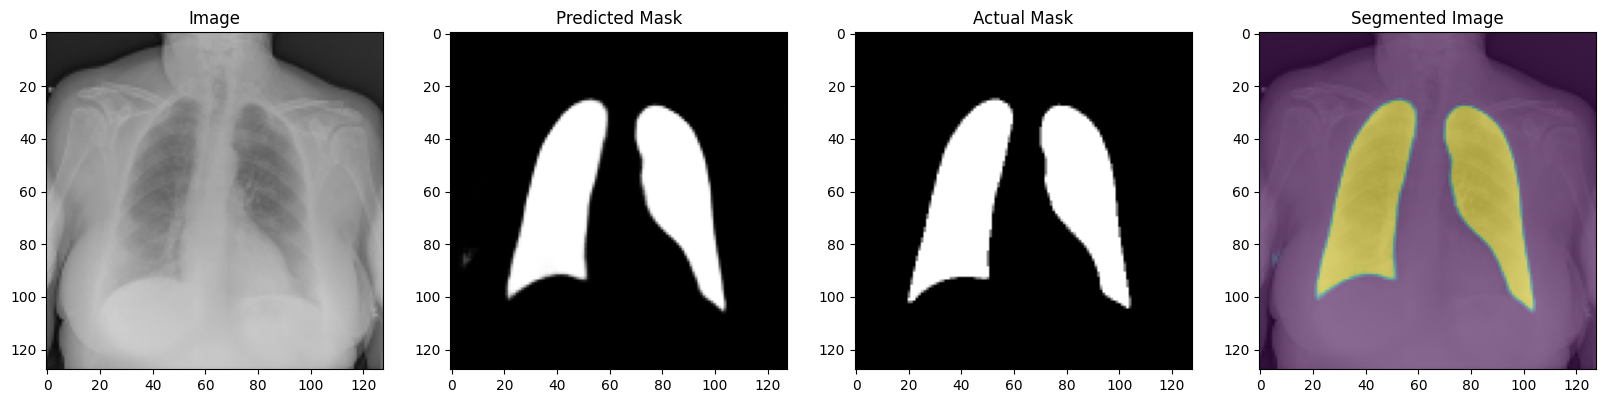

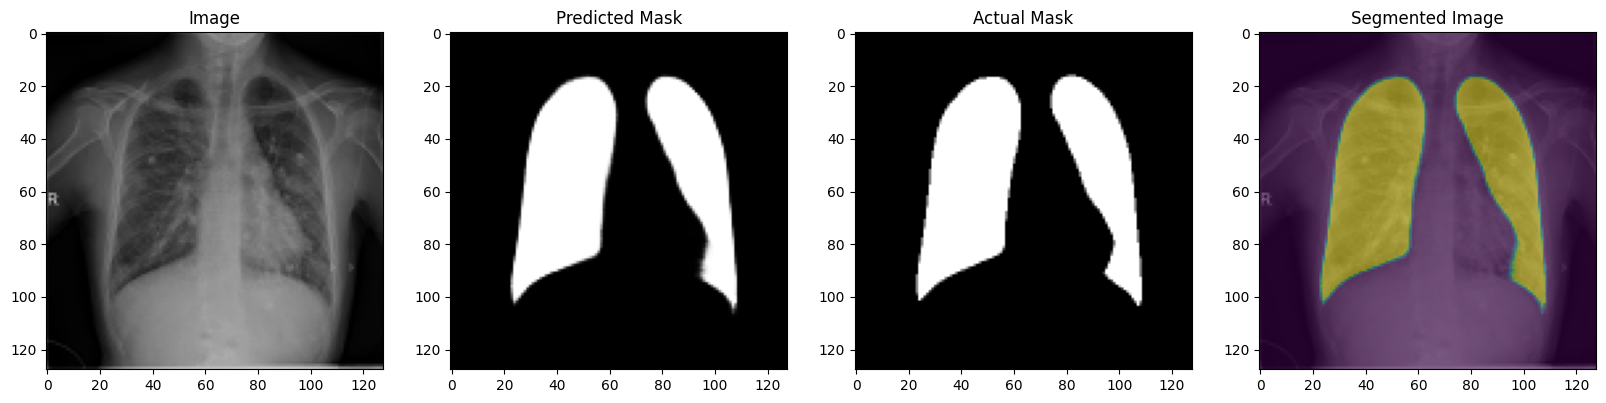

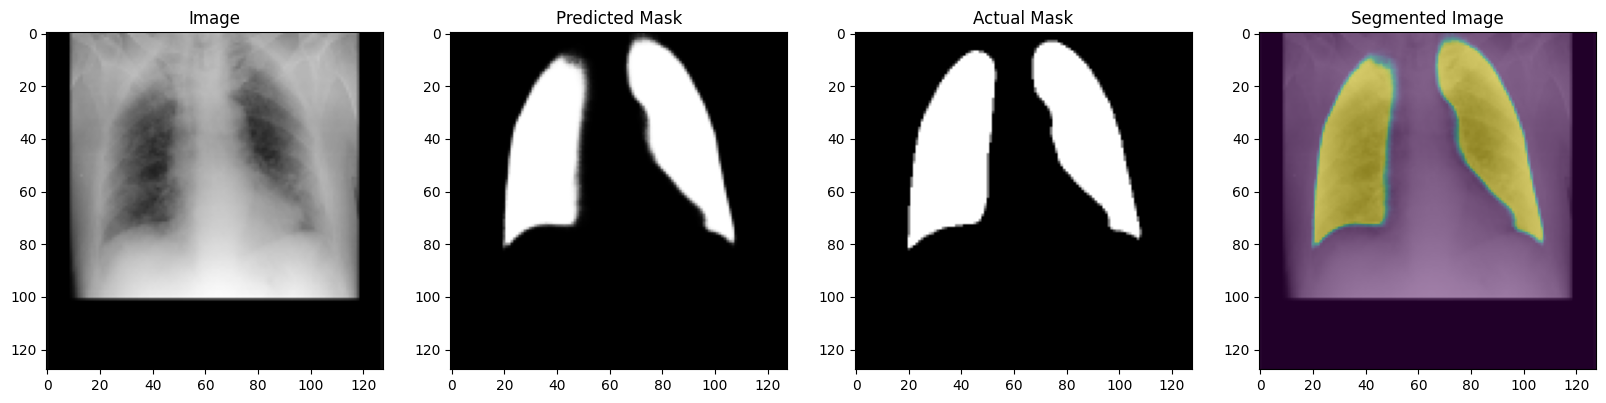

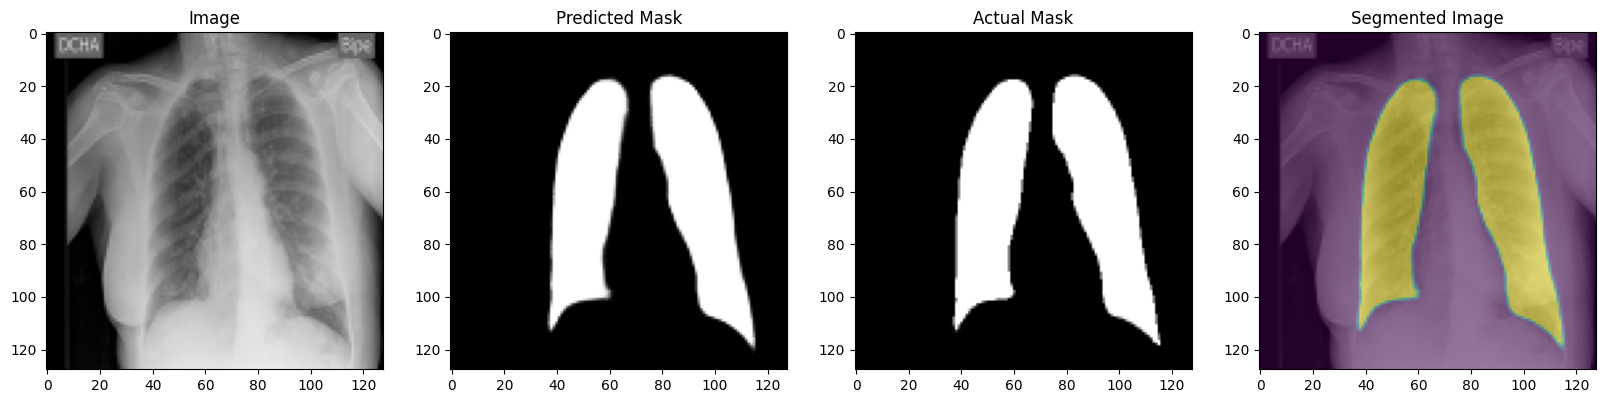

In [77]:
# Visualize the results

def plot_sample(image, mask, pred_mask):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(image.squeeze(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(pred_mask.squeeze(), cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[2].imshow(mask.squeeze(), cmap='gray')
    axs[2].set_title('Actual Mask')
    axs[3].imshow(image.squeeze(), cmap='gray')
    axs[3].imshow(pred_mask.squeeze(), alpha=0.5)
    axs[3].set_title('Segmented Image')
    plt.show()

# Display a few samples

for i in range(5):
    plot_sample(X_val[i], y_val[i], preds[i])

In [82]:
y_val = np.array([0.1, 0.7, 0.3, 0.9, 0.4])
val_preds = np.array([0.2, 0.8, 0.4, 0.9, 0.6])

# Ensure y_val and val_preds contain binary values

y_val_binary = (y_val > 0.5).astype(int)
val_preds_binary = (val_preds > 0.5).astype(int)

# Flatten the arrays for metric calculation

y_val_flat = y_val_binary.flatten()
val_preds_binary_flat = val_preds_binary.flatten()

# Calculate metrics

val_accuracy = accuracy_score(y_val_flat, val_preds_binary_flat)
val_precision = precision_score(y_val_flat, val_preds_binary_flat)
val_recall = recall_score(y_val_flat, val_preds_binary_flat)
val_f1_score = sklearn_f1_score(y_val_flat, val_preds_binary_flat)
val_jaccard_index = jaccard_score(y_val_flat, val_preds_binary_flat)

# Dice coefficient is often computed using the F1 score for binary classification problems

val_dice_coefficient = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Validation Jaccard Index: {val_jaccard_index:.4f}")
print(f"Validation Dice Coefficient: {val_dice_coefficient:.4f}")


Validation Accuracy: 0.8000
Validation Precision: 0.6667
Validation Recall: 1.0000
Validation F1 Score: 0.8000
Validation Jaccard Index: 0.6667
Validation Dice Coefficient: 0.8000


In [79]:
# Displaying all the metrics in percentage

val_accuracy_percent = val_accuracy * 100
val_precision_percent = val_precision * 100
val_recall_percent = val_recall * 100
val_f1_score_percent = val_f1_score * 100
val_jaccard_index_percent = val_jaccard_index * 100
val_dice_coefficient_percent = val_dice_coefficient * 100

print(f"Validation Accuracy: {val_accuracy_percent:.2f} %")
print(f"Validation Precision: {val_precision_percent:.2f} %")
print(f"Validation Recall: {val_recall_percent:.2f}%")
print(f"Validation F1 Score: {val_f1_score_percent:.2f} %")
print(f"Validation Jaccard Index: {val_jaccard_index_percent:.2f} %")
print(f"Validation Dice Coefficient: {val_dice_coefficient_percent:.2f} %")

Validation Accuracy: 80.00 %
Validation Precision: 66.67 %
Validation Recall: 100.00%
Validation F1 Score: 80.00 %
Validation Jaccard Index: 66.67 %
Validation Dice Coefficient: 80.00 %
